# Welter
## Issue 18- LkCa 4 photometry analysis


July, 2016

## TrES data--
Can we make a waterfall?

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')

In [3]:
import pandas as pd

##SuperWASP

In [7]:
#! head ../data/photometry/1SWASP_J041628.10+280735.5.csv

In [8]:
sw_cols = ['HJD','camera','mag','mag_err']
sw = pd.read_csv('../data/photometry/1SWASP_J041628.10+280735.5.csv', names=sw_cols, skiprows=1)

In [9]:
#sw.head()

(13.5, 12.0)

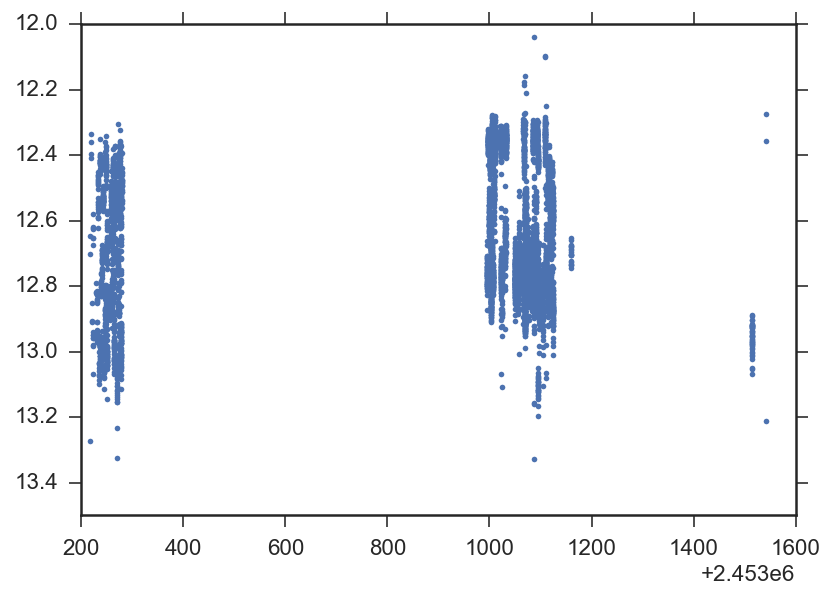

In [10]:
plt.plot(sw.HJD, sw.mag, '.')
plt.ylim(13.5, 12.0)

Waterfall

Make a new dataframe

In [12]:
sw.columns

Index(['HJD', 'camera', 'mag', 'mag_err'], dtype='object')

In [13]:
sw.head()

,HJD,camera,mag,mag_err
0,2.453216e+06,103,18.2177,406.0789
1,2.453217e+06,103,13.2721,0.0994
2,2.453218e+06,103,12.7014,0.0755
3,2.453218e+06,103,12.6479,0.1035
4,2.453219e+06,103,12.3588,0.0315


In [16]:
sw['floor_div'] = np.floor_divide(sw.HJD, 3.375)

sw['phase'] = np.mod(sw.HJD, 3.375)

sw['shift_delta'] = sw['floor_div'] - np.nanmin(sw['floor_div'])

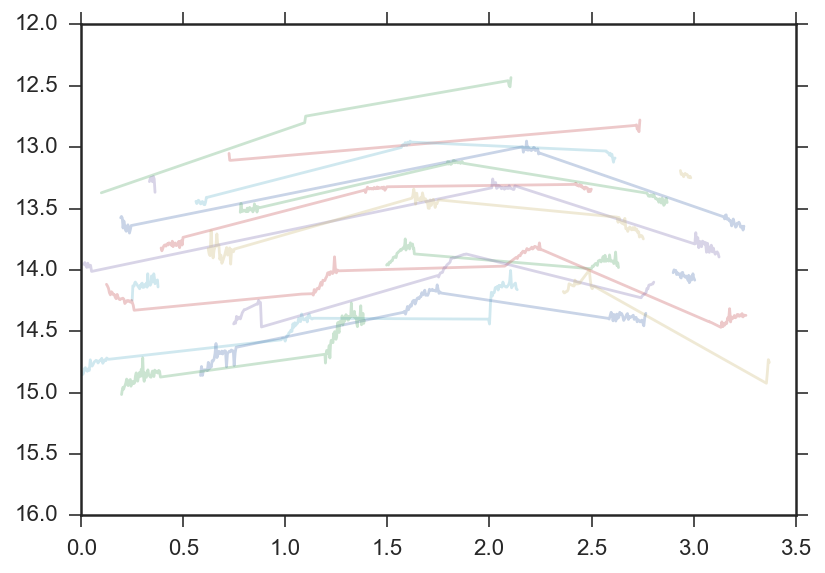

In [31]:
for id1, group in pd.groupby(sw, by='floor_div'):
    #print(id1)
    plt.plot(group.phase, group.mag+group['shift_delta']*0.1, '-', alpha=0.3)
    plt.ylim(16, 12.0)

## TrES
From Devor et al. 2008, from a website that differed from the one in the footnote of the 2008 paper.  
Unfortunately this is $r-$band photometry

In [32]:
#! head ../data/photometry/TrES_rband_T-Tau0-01262.lc

In [33]:
cols = ['HJD-2400000', 'r_band', 'r_unc']
TrES = pd.read_csv('../data/photometry/TrES_rband_T-Tau0-01262.lc', names=cols, delim_whitespace=True)

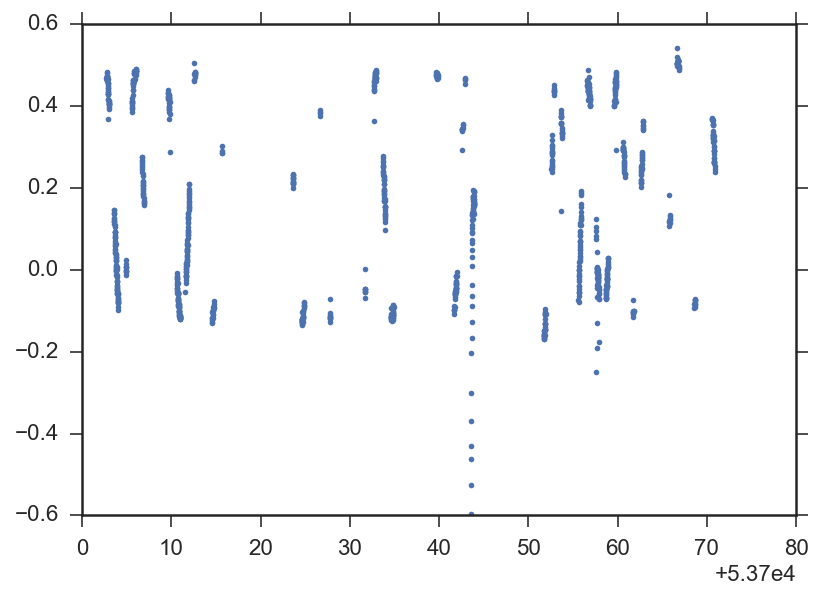

In [34]:
plt.plot(TrES['HJD-2400000'], TrES.r_band, '.')

The data is "normalized", is that just mean-subracted?  

(0.6, -0.5)

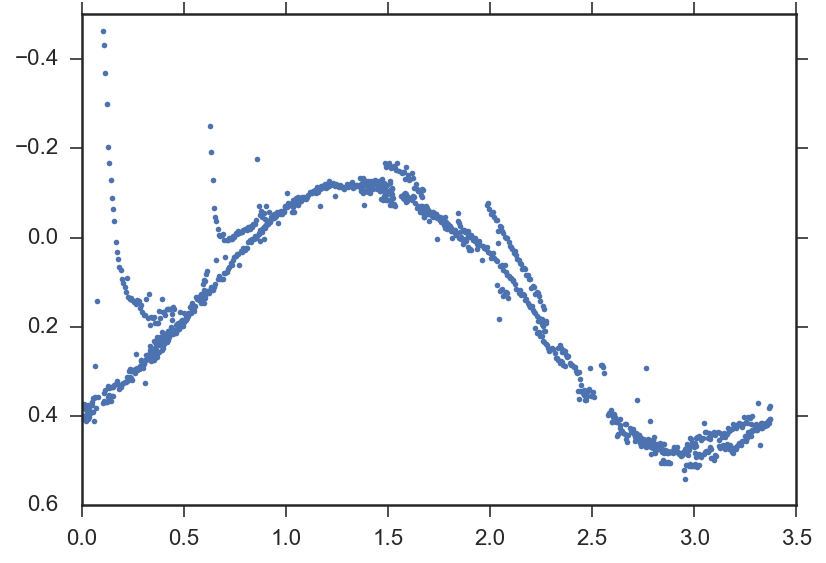

In [35]:
plt.plot(np.mod(TrES['HJD-2400000'], 3.375), TrES.r_band, '.')
plt.ylim(0.6, -0.5)

In [54]:
TrES['JD_like']=TrES['HJD-2400000']+2400000.0

In [39]:
TrES['floor_div'] = np.floor_divide(TrES['HJD-2400000'], 3.375)
TrES['phase'] = np.mod(TrES['HJD-2400000'], 3.375)
TrES['shift_delta'] = TrES['floor_div'] - np.nanmin(TrES['floor_div'])

In [ ]:
from astroML.time_series import multiterm_periodogram
from astroML.time_series import lomb_scargle

In [48]:
from gatspy.periodic import LombScargle, LombScargleFast

In [49]:
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit

In [51]:
uniq_cycles = TrES.floor_div.unique()
n_cycles = len(uniq_cycles)

In [53]:
master = TrES

In [63]:
reg

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0.1,  0.1,  0.1,  0.1])

(2.5, -0.2)

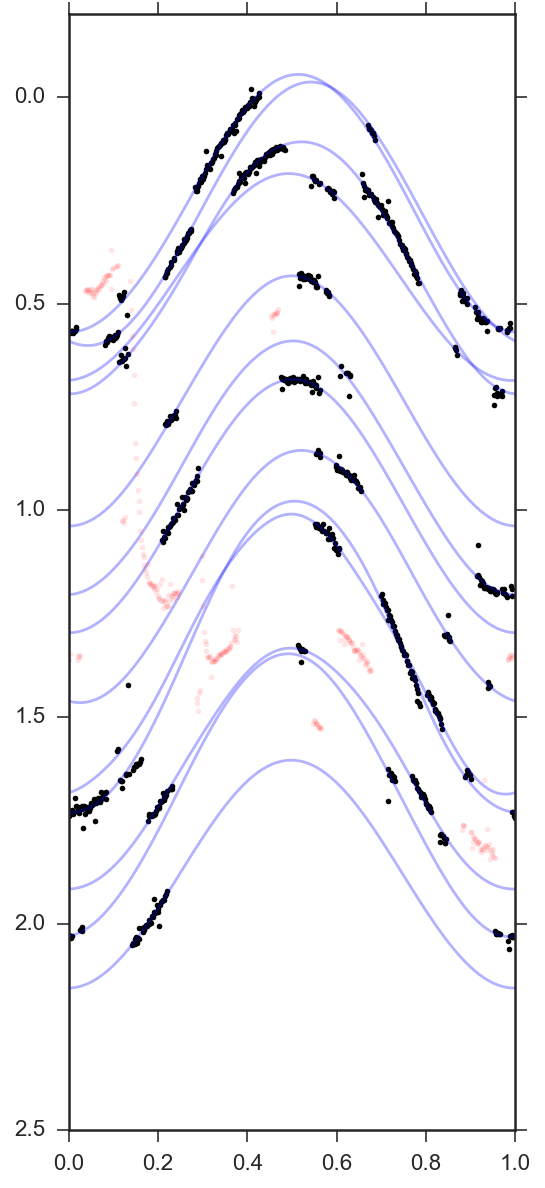

In [130]:
plt.figure(figsize=(4, 10))
for i in range(n_cycles):
    # get the data and best-fit angular frequency
    s = uniq_cycles[i]
    ids = master.floor_div == s
    df = master[ids]
    t = df.JD_like.values
    y = df.r_band.values
    dy = df.r_band.values*0.0+0.001
    this_P = 3.375
    phased_t = np.mod(t, this_P)/this_P
    
    # Fit a multiterm model
    Nterms = 4
    reg = 0.1 * np.ones(2 * Nterms + 1)
    reg[:3] = 0 # no regularization on low-order terms

    model = LombScargle(Nterms=4, regularization=reg)
    mask = y == y # We can mask flares later on
    model.fit(t[mask], y[mask], dy[mask])
    tfit = np.linspace(0, this_P, 100)
    yfit = model.predict(tfit, period=this_P)
    
    dh = 0.08
    
    if i not in [0, 6, 9, 11, 14, 17]:
        plt.plot(phased_t, y+df.shift_delta*dh, '.k', alpha=1.0)
        plt.plot(tfit/this_P, yfit+df.shift_delta.min()*dh, 'b', alpha=0.3)
        
    if i in [0, 6, 9, 11, 14, 17]:
        plt.plot(phased_t, y+df.shift_delta*dh, '.r', alpha=0.1)

plt.ylim(2.5,-0.2)

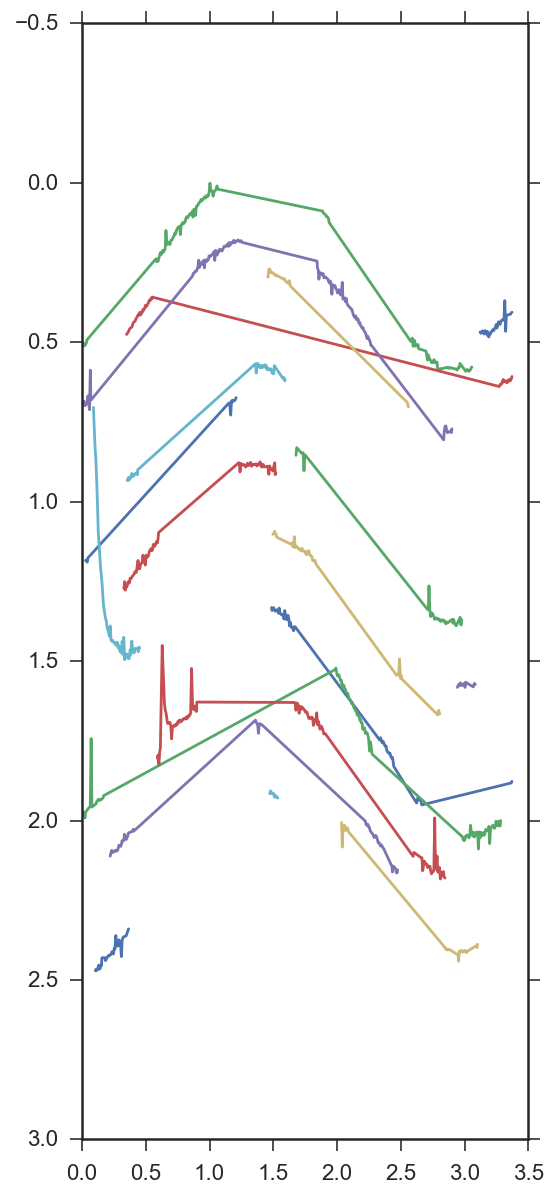

In [47]:
plt.figure(figsize=(4, 10))
for id1, group in pd.groupby(TrES, by='floor_div'):
    #print(id1)
    plt.plot(group.phase, group.r_band+group['shift_delta']*0.1, '-', alpha=1.0)
    plt.ylim(3, -0.5)

## The end.